In [33]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from lightgbm import Dataset
from lightgbm import *
%matplotlib inline

In [34]:
train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")
train.head()

,user_id,user_agent,entry_date,open_date,birthday,id_status,gender,blood_type,pay_method_type,course_name,price_type,entry_from,privilege_name,prefecture,close_flag
0,YKJGBC19356,Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_9_4...,2016-12-29,2017-01-26,1964-04-10,新規,男性,A,クレジットカード,@nifty光,マンション2年プラン,代理店取次,キャッシュバック還元,鹿児島,0
1,JMFEBB08712,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,2018-04-21,2018-05-29,1980-11-24,新規,女性,O,クレジットカード,@nifty光,ホーム2年プラン,代理店取次,付帯サービス無料,北海道,0
2,EXLFTB26665,Mozilla/5.0 (iPhone; CPU iPhone OS 3_1_3 like ...,2015-11-28,2016-04-05,1972-08-01,既存,女性,AB,クレジットカード,@nifty auひかり,ホーム2年プラン,ノジマ取次,月額割引還元,長野,0
3,MWEEMY19722,Opera/8.10.(X11; Linux i686; nn-NO) Presto/2.9...,2019-07-16,2019-08-15,1966-03-15,新規,男性,B,クレジットカード,@nifty光,マンション2年プラン,代理店取次,キャッシュバック還元,福島,0
4,WWTLYT31226,Mozilla/5.0 (iPad; CPU iPad OS 4_2_1 like Mac ...,2019-09-12,2020-01-06,1988-04-29,新規,男性,A,クレジットカード,@nifty auひかり,マンション3年プラン,WEB代理店,付帯サービス無料,愛知,0


In [35]:
#欠損値の削除
train=train.dropna()
test=test.dropna()

In [36]:
#object型➡datetime64型の変換
train["X"]=pd.to_datetime(train["birthday"],format="%Y-%m-%d")

#年齢のcolumnを追加
train["age"]=2020-train["X"].dt.year

train=train[train["age"]>=20]
train=train[train["age"]<=80]
#標準化
train["age"]=scipy.stats.zscore(train["age"])

#object型➡datetime64型の変換
test["X"]=pd.to_datetime(test["birthday"],format="%Y-%m-%d")

#年齢のcolumnを追加
test["age"]=2020-test["X"].dt.year

test=test[test["age"]>=20]
test=test[test["age"]<=80]
#標準化
test["age"]=scipy.stats.zscore(test["age"])

In [37]:
#インスタンス作成
le=LabelEncoder()
#ラベルの数値化
for column in ["gender","id_status","pay_method_type","course_name","price_type","entry_from","privilege_name","prefecture"]:
    le=le.fit(train[column])
    train[column]=le.transform(train[column])

for column in ["gender","id_status","pay_method_type","course_name","price_type","entry_from","privilege_name","prefecture"]:
    le=le.fit(test[column])
    test[column]=le.transform(test[column])

In [38]:
X=train.loc[:,["age","pay_method_type","course_name","price_type","privilege_name","prefecture"]].values
y=train.loc[:,["close_flag"]].values

KeyError: 'species'

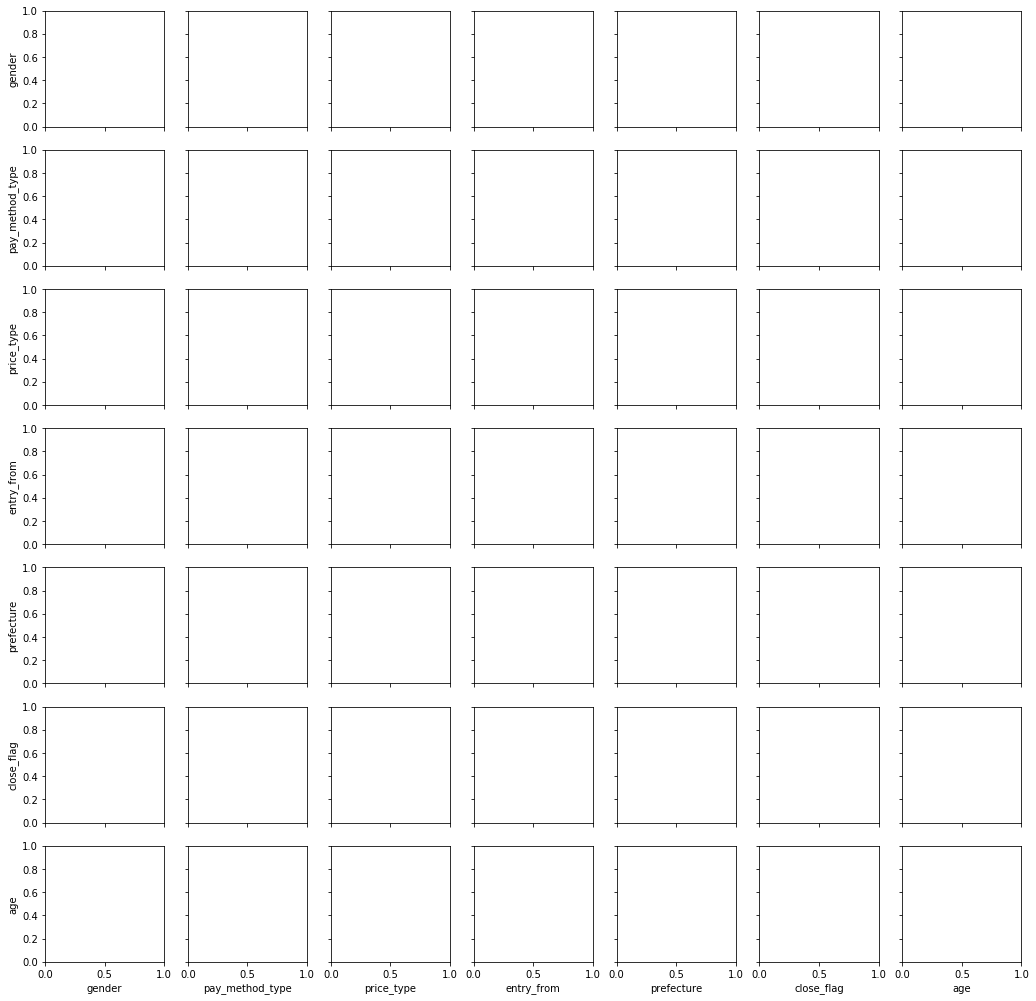

In [56]:
train=train.loc[:,["gender","pay_method_type","price_type","entry_from","prefecture","close_flag","age"]]
sns.pairplot(train, hue='species')


## LinearSVC

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
#y_trainを1行にする
y_train=np.reshape(y_train,-1)
y_test=np.reshape(y_test,-1)
#モデルの生成
model = LinearSVC(random_state=1)

In [40]:
#モデルの学習
model.fit(X_train,y_train)

C:\Users\riku\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(random_state=1)

In [41]:
#yの予測
y_pred=model.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9018914986489296

In [42]:
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(y_test,y_pred)
class_names=["0","1"]
df=pd.DataFrame(matrix,index=class_names,columns=class_names)
df

,0,1
0,26034,0
1,2832,0


## xgboost

In [43]:
# XGBoost が扱うデータセットの形式に直す
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
# 学習用のパラメータ
xgb_params = {
        # 二値分類問題
        'objective': 'binary:logistic',
        # 評価指標
        'eval_metric': 'logloss',
    }
# モデルを学習する
bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=100,  # 学習ラウンド数は適当
                    )

In [44]:
y_pred_proba = bst.predict(dtest)
y_pred_proba

array([0.18615592, 0.10684917, 0.20300873, ..., 0.00286511, 0.02079208,
       0.00637606], dtype=float32)

In [45]:
# しきい値 0.5 で 0, 1 に丸める
y_pred = np.where(y_pred_proba > 0.5, 1, 0)
# 精度 (Accuracy) を検証する
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

Accuracy: 0.9002632855262246


In [46]:
matrix=confusion_matrix(y_test,y_pred)
class_names=["0","1"]
df=pd.DataFrame(matrix,index=class_names,columns=class_names)
df

,0,1
0,25958,76
1,2803,29


## light gbm

In [48]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb.test = lgb.Dataset(X_test, y_test)
# 評価基準を設定する 
params = {'metric' : 'rmse'}

In [50]:
# 訓練データから回帰モデルを作る
gbm = lgb.train(params, lgb_train)
# テストデータを用いて予測精度を確認する
test_predicted = gbm.predict(X_test)
predicted_df = pd.concat([y_test.reset_index(drop=True), pd.Series(test_predicted)], axis = 1)
predicted_df.columns = ['true', 'predicted']
# 予測値を図で確認する関数の定義
def Prediction_accuracy(predicted_df):
    RMSE = np.sqrt(mean_squared_error(predicted_df['true'], predicted_df['predicted']))
    plt.figure(figsize = (7,7))
    ax = plt.subplot(111)
    ax.scatter('true', 'predicted', data = predicted_df)
    ax.set_xlabel('True Price', fontsize = 20)
    ax.set_ylabel('Predicted Price', fontsize = 20)
    plt.tick_params(labelsize = 15)
    x = np.linspace(5, 50)
    y = x
    ax.plot(x, y, 'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE,3))),transform = ax.transAxes, fontsize = 15)
# 予測値を図で確認する
Prediction_accuracy(predicted_df)

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

In [23]:
y_pred=gbm.predict(X_test)

NameError: name 'gbm' is not defined